In [1]:
import sys
sys.path.append('../utils')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import pygmt
import GravityFFT, GravityPrism, Gravity3DBlock

%load_ext autoreload
%autoreload 2


/opt/anaconda3/envs/pygmt7/lib/python3.8/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [30]:
region = [1.76e7, 1.82e7, -1.9e6, -1.3e6]
filter_width = 5000
grid_spacing = 2000
rho=1500
base_depth=10000


model_surface = pygmt.grdfilter(grid='/Users/simon/Work/TECTA/GMmodels/LHR_SS_topo18_2km.nc', 
                                distance=0, filter='g{:f}'.format(filter_width), 
                                region=region, spacing='{:f}'.format(grid_spacing))


#model_gravity = GravityPrism.okabe(model_surface, rho, base_depth, observation_height=0)



In [31]:
model_gravity_f = GravityFFT.parkergrav(model_surface.x.data, model_surface.y.data, model_surface.data, base_depth, rho/1000, 0)


z0 set to 0
104 405 104 405
finished iteration 1 ....
finished iteration 2 ....
finished iteration 3 ....
finished iteration 4 ....
finished iteration 5 ....
finished iteration 6 ....
finished iteration 7 ....
finished iteration 8 ....


/Users/simon/GIT/MBA/notebooks/../utils/Gravity3DBlock.py:56: RuntimeWarning: invalid value encountered in true_divide
  gf = (2 * np.pi * gamma * (np.exp(-k * z1) - np.exp(-k * z2))) / k


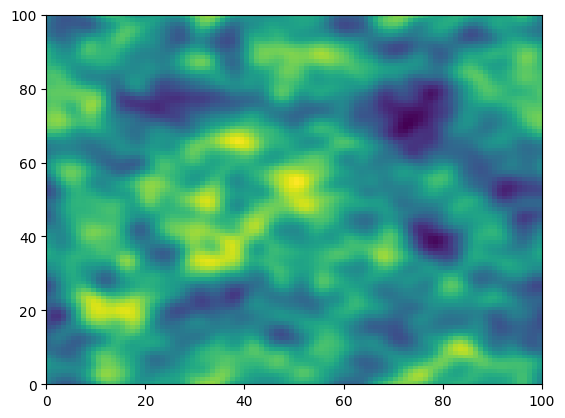

In [32]:
res = Gravity3DBlock.glayer(np.random.randn(100,100), 100, 2000,3000)

plt.pcolormesh(res)

In [33]:
region = [1.76e7, 1.82e7, -1.9e6, -1.3e6]
grid_spacing = 1000

free_air_gravity = pygmt.grdsample('/Users/simon/Work/TECTA/GMmodels/LHR_FAA_2km.nc', region=region, spacing=grid_spacing)
bathymetry = pygmt.grdsample('/Users/simon/Work/TECTA/GMmodels/LHR_SS_topo18_2km.nc', region=region, spacing=grid_spacing)
sediment_thickness = pygmt.grdsample('/Users/simon/Work/TECTA/GMmodels/LHR_SedThick_2km.nc', region=region, spacing=grid_spacing)


gt,mv = Gravity3DBlock.Forward_NoThermalAndPressureCorrection(free_air_gravity.data, 
                                                              bathymetry.data, 
                                                              sediment_thickness.data, 
                                                              bathymetry.x.data, 
                                                              bathymetry.y.data,
                                                              rhoBackground = 2500)


gridding model in 3D...
starting summation of layers


/Users/simon/GIT/MBA/notebooks/../utils/Gravity3DBlock.py:56: RuntimeWarning: invalid value encountered in true_divide
  gf = (2 * np.pi * gamma * (np.exp(-k * z1) - np.exp(-k * z2))) / k


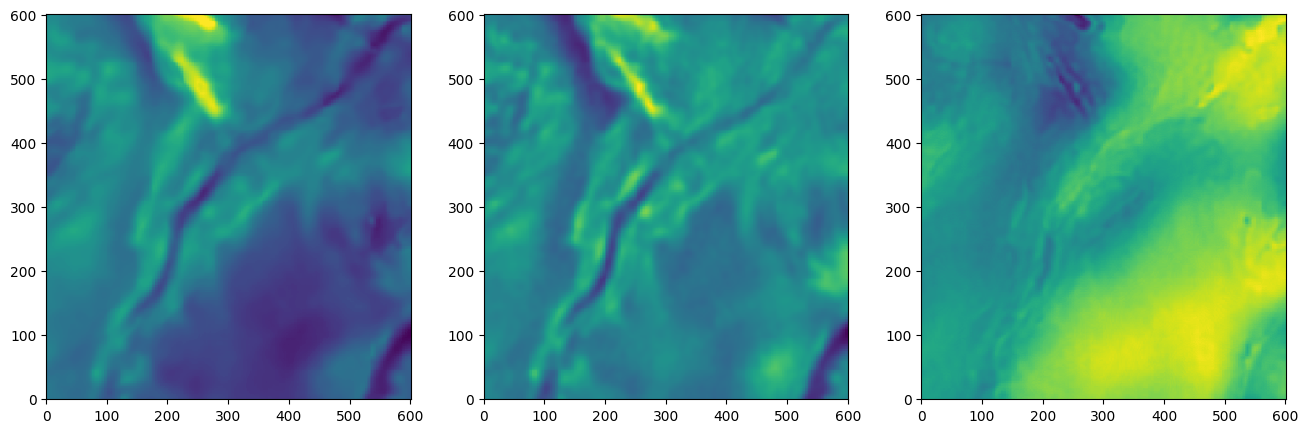

In [34]:
fig,axs = plt.subplots(1,3,figsize=(16,5))

axs[0].pcolormesh(-gt)

axs[1].pcolormesh(free_air_gravity.data)

axs[2].pcolormesh(gt+free_air_gravity.data)

plt.show()


grdproject [WARNING]: x_inc does not divide 180; geographic boundary condition changed to natural.
grdfilter [WARNING]: (x_max-x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
grdfilter [WARNING]: (y_max-y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
grdfilter (gmtapi_init_grdheader): Please select compatible -R and -I values


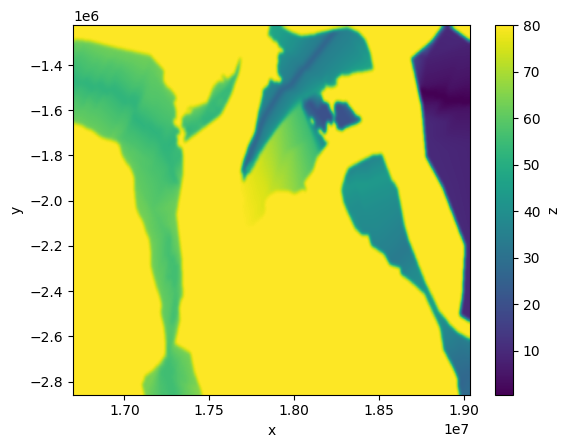

In [35]:
region = [150,171,-25,-11]
region_name = 'LHR'
filter_width = 50000

def project_to_mercator(grid, region, spacing):
    
    a = pygmt.grdproject(grid=grid, region=region, projection='EPSG:3395', spacing=spacing, interpolation='n')
    #b = pygmt.grdfill(a, mode='n')
    a.data[np.isnan(a.data)] = 80
    return a

    
#tmp = project_to_mercator('/Users/simon/Data/GMTdata/GravityGrids/DNSC08BAT_2min_rs.nc', region, 2000)
tmp = project_to_mercator('/Users/simon/Data/AgeGrids/2020/age.2020.1.GeeK2007.2m.nc', region, grid_spacing)
tmp = pygmt.grdfilter(tmp, distance=0, filter='g{:f}'.format(filter_width), 
                      spacing='{:f}'.format(grid_spacing))
tmp.plot()


In [36]:
print(gt.shape)
model_gravity = xr.DataArray(gt, coords=[('y',free_air_gravity.y.data), ('x',free_air_gravity.x.data)], name='z')
residual = free_air_gravity+gt

zinv = GravityFFT.oldenburg(residual.x.data, residual.y.data, residual.data, 1500, 6000)
zinv = xr.DataArray(zinv, coords=[('y',residual.y.data), ('x',residual.x.data)], name='z')

#Gravity3DBlock.AddThermalAndPressureCorrection(tmp.x.data, 
#                                               tmp.y.data,
#                                               tmp.data,
#                                               zinv)
#plt.pcolormesh(residual.data)
#plt.pcolormesh(zinv)
#plt.colorbar()
zinv


(601, 601)
210 811 210 811


<xarray.DataArray 'z' (y: 601, x: 601)>
array([[9937.70215225, 9937.54053454, 9937.37854459, ..., 9965.86224078,
        9966.0271566 , 9966.19220476],
       [9937.70929589, 9937.55329584, 9937.39696403, ..., 9966.29827644,
        9966.45193981, 9966.6052204 ],
       [9937.7156274 , 9937.56402857, 9937.41212083, ..., 9966.99438285,
        9967.13925009, 9967.28333256],
       ...,
       [9931.9232409 , 9932.54849667, 9933.11052677, ..., 9892.53637635,
        9890.61572652, 9888.58350004],
       [9931.93485186, 9932.54835895, 9933.09920086, ..., 9899.01029097,
        9896.83304988, 9894.52973831],
       [9931.94173539, 9932.54062435, 9933.07710595, ..., 9905.52361574,
        9903.11163789, 9900.56018194]])
Coordinates:
  * y        (y) float64 -1.9e+06 -1.899e+06 -1.898e+06 ... -1.301e+06 -1.3e+06
  * x        (x) float64 1.76e+07 1.76e+07 1.76e+07 ... 1.82e+07 1.82e+07

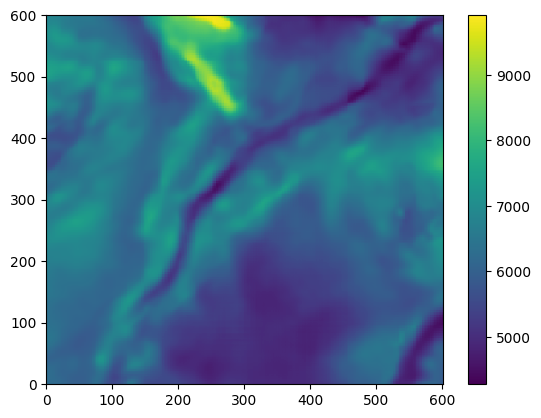

In [37]:
plt.pcolormesh(bathymetry - sediment_thickness + zinv)
plt.colorbar()

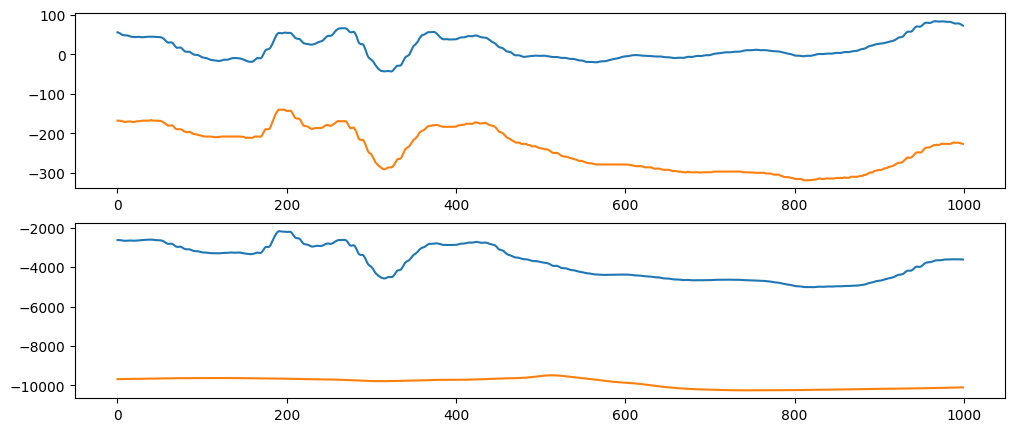

In [38]:
x1 = 1.77e7
y1 = -1.5e6
x2 = 1.81e7
y2 = -1.85e6
points = list(zip(np.linspace(x1,x2,1000), np.linspace(y1,y2,1000)))

pbath = pygmt.grdtrack(points=points, grid=bathymetry, 
                       newcolname='z', no_skip=True)
pfaa = pygmt.grdtrack(points=points, grid=free_air_gravity, 
                       newcolname='z', no_skip=True)
pzinv = pygmt.grdtrack(points=points, grid=zinv, 
                       newcolname='z', no_skip=True)
pgmod = pygmt.grdtrack(points=points, grid=model_gravity, 
                       newcolname='z', no_skip=True)

model_gravity

fig,ax = plt.subplots(nrows=2, figsize=(12,5))
ax[0].plot(pfaa.iloc[:,2])
ax[0].plot(-pgmod.iloc[:,2])
ax[1].plot(pbath.iloc[:,2])
ax[1].plot(-pzinv.iloc[:,2])
#pbath
